## Projet IAS - Data Processing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

### 1. Importation et traitement les données

In [3]:
# Référence des produits pour l'affichage des résultats
item_map = pd.read_csv('../data/ProductIdMapp.csv', sep=',')
item_map.set_index('ProdId', inplace=True)
item_map = item_map.rename(columns={'ItemName': 'Name'})
item_map.head()

,Name
ProdId,
100,MULTIVITAMINES GLOBAL 12 VIT+ 7 OLIGO ELEMENTS...
102,804 AIDE MINCEUR TRIPLE ACTION CP B/30 3CHENE
103,804 BRULE GRAISSE SOL BUV STABILISATEUR FL/500ML
104,804 PACK MINCEUR
105,804 SOUPE B/300G LEGUMES


In [4]:
df = pd.read_csv('mouvement.csv', sep=';')
df.head()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969
2,102,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,"ALLERGODIL 0,127MG/DOSE SPRAY NASAL FL/17ML MYLAN",221
3,103,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,BIRODOGYL B/10 CP PELLIC SANOFI,815
4,104,6,2019-08-08 14:56:17.520,1.0,NaN,100.0,NaN,NaN,0.0,1.0,CARVEDI-DENK 25MG CP B/30 DENK PHARMA,1062


In [5]:
df.shape

(1474451, 12)

In [6]:
df.columns

Index(['InventoryLogDetailId', 'BatchType', 'TransactionDate', 'Quantity',
       'FromLocationId', 'ToLocationId', 'FromQuantityBefore',
       'FromQuantityAfter', 'ToQuantityBefore', 'ToQuantityAfter', 'Name',
       'ProdId'],
      dtype='object')

**Explication du colonne 'BatchType'**

* BatchType = 1 : **Ajustement de stock** (positif ou négatif)

C'est un mouvement de stock qui est d'origine très variable. Il peut s'agir d'une erreur de vente/achat, d'un retour de produit, d'un produit périmé et aussi d'autres cas inexplicables, etc. Ce type de mouvement est pertinent car il indique l'état de stock de la pharmacie avant et après la vente.

* BatchType = 2 signifie **Transfert de stock** (neutre)

Il s'agit d'un mouvement de stock entre les emplacement internes de la pharmacie. Cela ne nous intéresse pas car il n'a aucun effet sur la variation du stock.

* BatchType = 3 signifie **Assortiment** (négatif car sortie de stock)
    Ce type de mouvement est pertinent car il indique l'états de stock de la pharamacie avant et après la vente.

* BatchType = 4 signifie une **Expédition**. 

Il indique la quantité de produits assortis prêts à être expédiés qui est appelé 'PICKED'. Ce mouvement ne nous intéresse pas car il est temporaire et n'a pas d'effet sur la variation du stock.
La suppression de ce mouvement est très importante car il s'apparie toujours au mouvement BatchType 3 (Assortiment). Donc ça va diminuer de moitié le nombre de lignes de ces deux catégories (3 et 4).

* BatchType = 5 signifie **Réapprovisionnement** (en général positif sauf erreur de saisie)

Il s'agit d'un mouvement de commander à nouveau des produits pour que le stock soit suffisant et permette de répondre à la demande. Cela aura un impact sur le stock de la pharmacie.

* BatchType = 6 signifie **Réception** (généralement positif sauf erreur de saisie)
Il s'agit d'un mouvement de stock qui indique que la pharmacie a reçu des produits achetés depuis les grossistes. Cela aura un impact sur le stock de la pharmacie.

Les lignes à éliminer sont celles qui ont BatchType = 2 et 4.

In [7]:
# Afficher les catégories de valeurs de la colonne 'BatchType'
df['BatchType'].unique()

array([6, 3, 4, 5, 1, 7, 2], dtype=int64)

In [8]:
# Comparer les nombres des 'BatchType' de catégorie 2 et 4 par rapport au total
df.shape[0], df[df['BatchType'].isin([2, 4])].shape[0]

(1474451, 638706)

In [9]:
# Eliminer les lignes avec 'BatchType' 2 et 4
df = df[~df['BatchType'].isin([2, 4])]

In [10]:
# Vérification
df.shape[0], df[df['BatchType'].isin([2, 4])].shape[0]

(835745, 0)

In [11]:
def fill_columns(row):
    if row['BatchType'] in [1, 5]:
        if np.isnan(row['FromLocationId']):
            row['LastStock'] = row['ToQuantityBefore']
            row['CurrentStock'] = row['ToQuantityAfter']
        else:
            row['Quantity'] *= -1
            row['LastStock'] = row['FromQuantityBefore']
            row['CurrentStock'] = row['FromQuantityAfter']
    elif row['BatchType'] == 3:
        row['Quantity'] *= -1
        row['LastStock'] = row['FromQuantityBefore']
        row['CurrentStock'] = row['FromQuantityAfter']
    elif row['BatchType'] == 6:
        if np.isnan(row['FromLocationId']):
            row['LastStock'] = row['ToQuantityBefore']
            row['CurrentStock'] = row['ToQuantityAfter']
        else:
            row['Quantity'] *= -1
            row['LastStock'] = row['FromQuantityBefore']
            row['CurrentStock'] = row['FromQuantityAfter']
    else:
        row['LastStock'] = 0
        row['CurrentStock'] = 0
    return row

In [12]:
# Create the two new columns and apply the function to each row
df['LastStock'] = 0
df['CurrentStock'] = 0
df = df.apply(fill_columns, axis=1)

# Display the updated DataFrame
df.head()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968,0.0,80.0
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969,0.0,12.0
2,102,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,"ALLERGODIL 0,127MG/DOSE SPRAY NASAL FL/17ML MYLAN",221,0.0,2.0
3,103,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,BIRODOGYL B/10 CP PELLIC SANOFI,815,0.0,2.0
4,104,6,2019-08-08 14:56:17.520,1.0,NaN,100.0,NaN,NaN,0.0,1.0,CARVEDI-DENK 25MG CP B/30 DENK PHARMA,1062,0.0,1.0


In [13]:
df.tail()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
1474441,1507682,3,2025-04-06 16:43:31.793,-2.0,101.0,1.0,298.0,296.0,0.0,2.0,FERVEX AD AVEC SUCRE SACH DET UPSA,1863,298.0,296.0
1474443,1507684,3,2025-04-06 16:43:35.063,-1.0,101.0,1.0,59.0,58.0,0.0,1.0,PARACETAMOL 500MG DET PL/10,3616,59.0,58.0
1474444,1507685,3,2025-04-06 16:43:35.063,-1.0,101.0,1.0,8.0,7.0,0.0,1.0,PRESA PRESERVATIF B/3,6590,8.0,7.0
1474447,1507688,3,2025-04-06 16:43:37.327,-1.0,101.0,1.0,79.0,78.0,0.0,1.0,NAUTAMINE 90MG CP DET SANOFI AVENTIS,3248,79.0,78.0
1474449,1507690,3,2025-04-06 16:43:39.933,-1.0,101.0,1.0,86.0,85.0,0.0,1.0,"SSI 0,9% FL/500ML POCHE PLASTIQUE",4342,86.0,85.0


In [14]:
df[(df['BatchType']==6) & df['FromLocationId'].isnull()].head(2)

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968,0.0,80.0
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969,0.0,12.0


In [15]:
df[(df['BatchType']==6) & df['FromLocationId']].head(2)

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
1299,1404,6,2019-08-12 11:50:31.353,-10.0,100.0,NaN,8.0,-2.0,NaN,NaN,YENDOL SACH DET,4934,8.0,-2.0
1376,1481,6,2019-08-12 13:12:08.780,-16.0,100.0,NaN,9.0,-7.0,NaN,NaN,FERVEX AD AVEC SUCRE SACH DET UPSA,1863,9.0,-7.0


In [16]:
df.drop(columns = ['InventoryLogDetailId', 'FromLocationId', 'ToLocationId', 'FromQuantityBefore', 'FromQuantityAfter', 'ToQuantityBefore', 'ToQuantityAfter'], inplace=True)
df.head()

,BatchType,TransactionDate,Quantity,Name,ProdId,LastStock,CurrentStock
0,6,2019-08-08 01:36:28.523,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968,0.0,80.0
1,6,2019-08-08 01:36:28.523,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969,0.0,12.0
2,6,2019-08-08 14:56:17.520,2.0,"ALLERGODIL 0,127MG/DOSE SPRAY NASAL FL/17ML MYLAN",221,0.0,2.0
3,6,2019-08-08 14:56:17.520,2.0,BIRODOGYL B/10 CP PELLIC SANOFI,815,0.0,2.0
4,6,2019-08-08 14:56:17.520,1.0,CARVEDI-DENK 25MG CP B/30 DENK PHARMA,1062,0.0,1.0


### 2. Analyse Exploratoire des Données

**2.1. Compréhension générales des données**

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 835745 entries, 0 to 1474449
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BatchType        835745 non-null  int64  
 1   TransactionDate  835745 non-null  object 
 2   Quantity         835745 non-null  float64
 3   Name             835745 non-null  object 
 4   ProdId           835745 non-null  int64  
 5   LastStock        835745 non-null  float64
 6   CurrentStock     835745 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 51.0+ MB


In [18]:
df[['Quantity', 'CurrentStock']].describe()

,Quantity,CurrentStock
count,835745.000000,835745.000000
mean,0.014948,-150.179469
std,15.312081,1333.479662
min,-2770.000000,-16420.000000
25%,-1.000000,1.000000
50%,-1.000000,5.000000
75%,-1.000000,17.000000
max,2700.000000,4920.000000


**2.2. Analyse des mouvements de stock**

*Effectif par type de mouvement de stock*

In [19]:
df['BatchType'].value_counts()

BatchType
3    637577
6    191421
1      6292
7       411
5        44
Name: count, dtype: int64

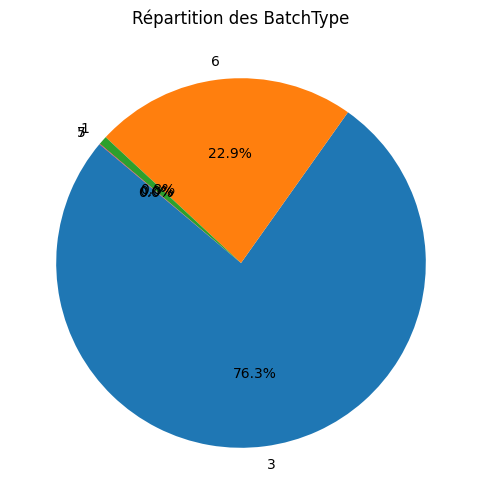

In [20]:
# Visualisation en camembert de la répartition des effectifs pour chaque catégorie de Mouvement
effectif = df['BatchType'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(effectif, labels=effectif.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des BatchType')
plt.ylabel('')
plt.show()



*Quantité en mouvement de stock par type de mouvement de stock*

In [21]:
# Regrouper les données par 'BatchType' et calculer la somme des 'Quantity'
quantite_par_batch = df.copy()
quantite_par_batch = quantite_par_batch[['BatchType', 'Quantity']].groupby('BatchType').sum().reset_index()
quantite_par_batch = quantite_par_batch.rename(columns={'Quantity': 'TotalQuantity'})
quantite_par_batch['TotalQuantity'] = quantite_par_batch['TotalQuantity'].abs()

In [22]:
quantite_par_batch['Type'] = quantite_par_batch['BatchType'].map({1: 'Ajustement', 3: 'Assortiment', 5: 'Réapprovisionnement', 6: 'Reception', 7: 'Non défini'})
quantite_par_batch['pourcentage'] = quantite_par_batch['TotalQuantity'] / quantite_par_batch['TotalQuantity'].sum() * 100
quantite_par_batch

,BatchType,TotalQuantity,Type,pourcentage
0,1,1956.0,Ajustement,0.093579
1,3,1036906.0,Assortiment,49.607577
2,5,133.0,Réapprovisionnement,0.006363
3,6,1046286.0,Reception,50.056334
4,7,4936.0,Non défini,0.236148


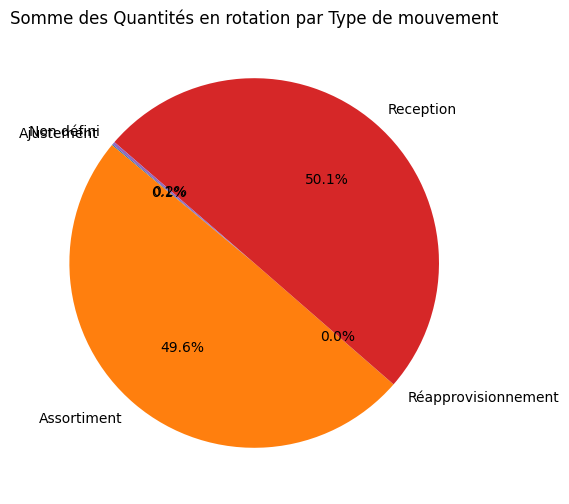

In [23]:
# Visualisation de la somme des 'Quantity' par 'BatchType'
plt.figure(figsize=(10, 6))
plt.pie(quantite_par_batch['TotalQuantity'], labels=quantite_par_batch['Type'], autopct='%1.1f%%', startangle=140)
plt.title('Somme des Quantités en rotation par Type de mouvement')
plt.ylabel('')
plt.show()

**Groupement par produit**

In [24]:
# Calculer la moyenne des quantités par produit
s_1 = df.copy()

s_1 = s_1[['ProdId', 'Quantity']].groupby('ProdId').agg(
    Moves=('ProdId', 'count'),
    Quantity=('Quantity', 'mean')
).reset_index()

#s_1 = s_1[['ProdId', 'Quantity']].groupby('ProdId').sum().reset_index()


In [25]:
s_1.head()

,ProdId,Moves,Quantity
0,100,77,0.025974
1,102,12,0.000000
2,103,4,0.000000
3,104,33,0.000000
4,105,26,0.038462


In [26]:
s_1.describe()

,ProdId,Moves,Quantity
count,5885.000000,5885.000000,5885.000000
mean,4189.507052,142.012744,0.425650
std,2280.022359,454.631319,7.839451
min,100.000000,1.000000,-9.315789
25%,2151.000000,8.000000,0.000000
50%,4420.000000,31.000000,0.000000
75%,6184.000000,124.000000,0.040541
max,7779.000000,16886.000000,250.000000


Affichage des 5 premiers produits ayant le plus de quantités positives en stock.

In [27]:
s_1.sort_values(by='Quantity', ascending=False, inplace=True, ignore_index=True)
s_1.head()

,ProdId,Moves,Quantity
0,6222,6,250.000000
1,5382,2,250.000000
2,6214,12,232.916667
3,5524,7,221.571429
4,5559,1,200.000000


In [28]:
s_1.describe()

,ProdId,Moves,Quantity
count,5885.000000,5885.000000,5885.000000
mean,4189.507052,142.012744,0.425650
std,2280.022359,454.631319,7.839451
min,100.000000,1.000000,-9.315789
25%,2151.000000,8.000000,0.000000
50%,4420.000000,31.000000,0.000000
75%,6184.000000,124.000000,0.040541
max,7779.000000,16886.000000,250.000000


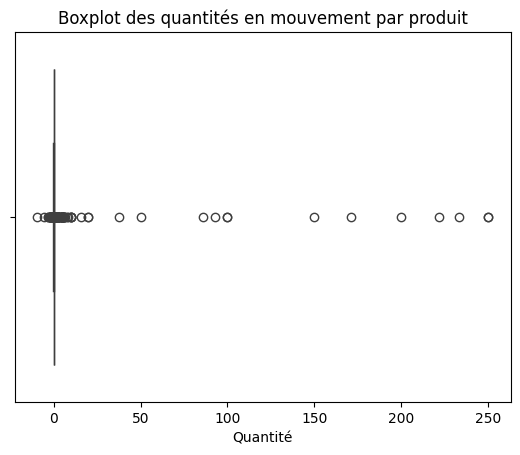

In [29]:
# Visualisation des valeures aberrantes
sns.boxplot(x=s_1['Quantity'])
plt.title('Boxplot des quantités en mouvement par produit')
plt.xlabel('Quantité')
plt.show()

Text(0.5, 1.0, 'Scatter plot of Moves vs QuantityMean')

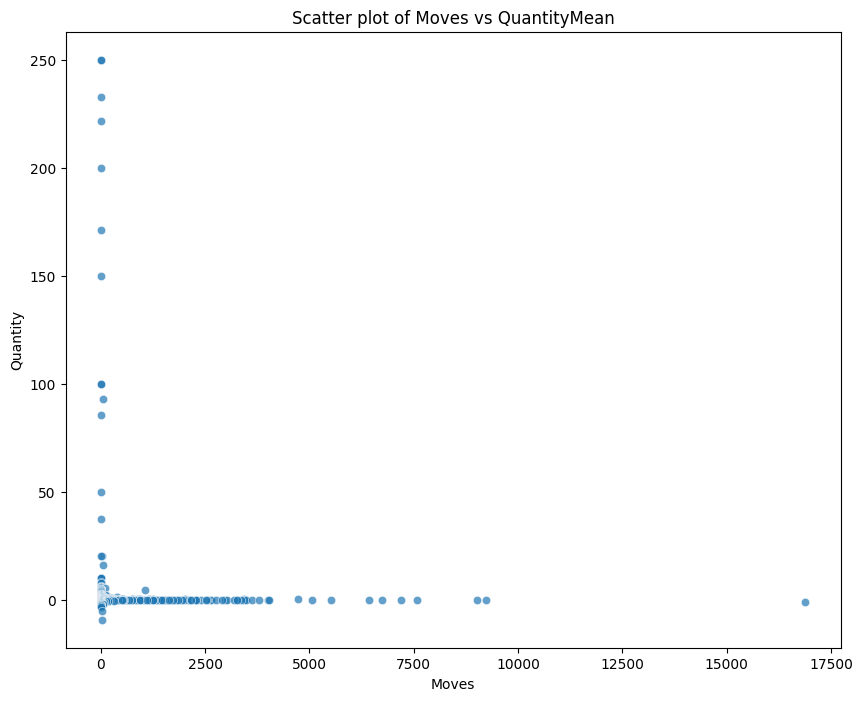

In [30]:
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=s_1,
    x='Moves',
    y='Quantity',
    sizes=(20, 200),
    alpha=0.7
)
ax.set_title('Scatter plot of Moves vs QuantityMean')

D'après la visualisation, la plupart des produits en surstock ont peu de mouvements. Et ceux qui sont en forte rotation sont en général équilibrés en quantité de mouvements. Pour la suite, on va isoler l'étude des produits qui sont en surstock mais peu de mouvements par rapport aux reste.

**5.2. Construction d'un modèle de classification**

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [32]:
X = s_1[['Moves', 'Quantity']].values
print(X[:5])

XS = StandardScaler().fit_transform(X)

print(XS[:5])

[[  6.         250.        ]
 [  2.         250.        ]
 [ 12.         232.91666667]
 [  7.         221.57142857]
 [  1.         200.        ]]
[[-0.29919694 31.83839936]
 [-0.30799603 31.83839936]
 [-0.28599832 29.65906487]
 [-0.29699717 28.21174378]
 [-0.3101958  25.45985938]]


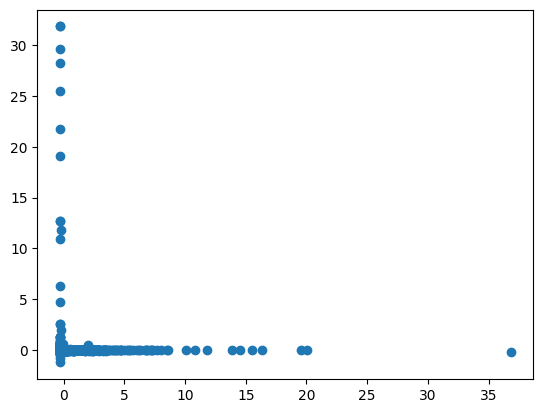

In [33]:
plt.scatter(XS[:, 0], XS[:, 1])
plt.show()

In [34]:
db = DBSCAN(eps=0.5, min_samples=5).fit(XS)

In [35]:
print(db.labels_)

[-1 -1 -1 ...  0  0  0]


In [36]:
s_2 = s_1.copy()
s_2['DB_Cluster'] = db.labels_
s_2.head()

,ProdId,Moves,Quantity,DB_Cluster
0,6222,6,250.000000,-1
1,5382,2,250.000000,-1
2,6214,12,232.916667,-1
3,5524,7,221.571429,-1
4,5559,1,200.000000,-1


In [37]:
s_2['DB_Cluster'].value_counts()

DB_Cluster
 0    5845
-1      29
 1      11
Name: count, dtype: int64

Text(0.5, 1.0, 'DBSCAN Clustering of Moves vs QuantityMean')

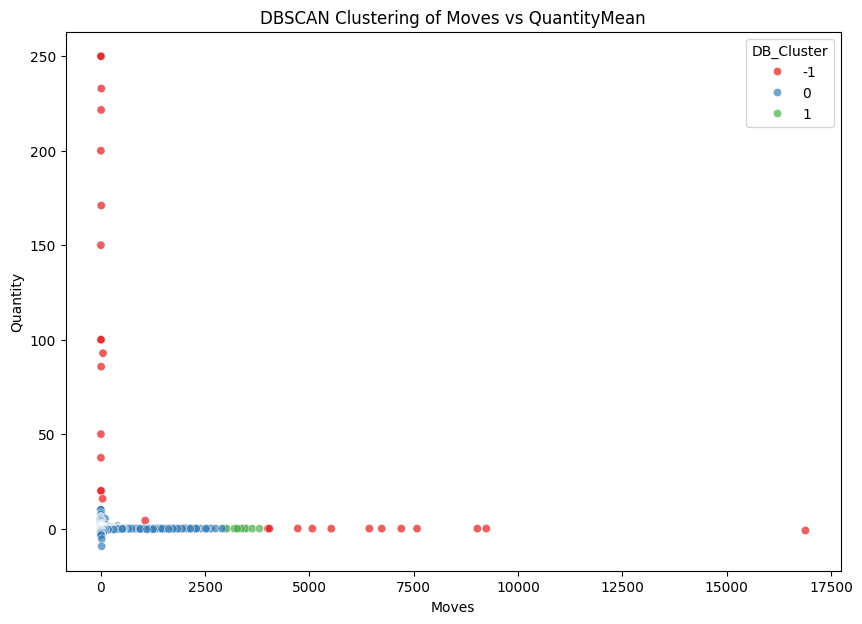

In [38]:
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=s_2,
    x='Moves',
    y='Quantity',
    hue='DB_Cluster',
    palette='Set1',
    sizes=(20, 200),
    alpha=0.7
)
ax.set_title('DBSCAN Clustering of Moves vs QuantityMean')

In [39]:
# Evaluer la qualité du clustering DBSCAN
from sklearn.metrics import silhouette_score

# Calculer le score de silhouette
db_score = silhouette_score(XS, db.labels_)
print(f"DBSCAN Silhouette Score: {db_score:.2f}")

DBSCAN Silhouette Score: 0.93


```python
exces = s_2[(s_2['KM_Cluster'] == 0) & (s_2['Quantity'] > seuil_exces)].copy()
exces = exces.merge(item_map, on='ProdId', how='left')
exces = exces[['Name', 'Moves', 'Quantity']]
exces
```

In [40]:
# Afficher 
seuil_exces = 1
classe = -1

dbs_surstock = s_2[(s_2['DB_Cluster'] == classe) & (s_2['Quantity'] > seuil_exces)].copy()
dbs_surstock = dbs_surstock.merge(item_map, on ='ProdId', how='left')
dbs_surstock = dbs_surstock[['Name', 'Moves', 'Quantity']]
dbs_surstock


,Name,Moves,Quantity
0,BOUTEILLE PET 0.5 L RONDE,6,250.000000
1,MASQUE COQUE DET,2,250.000000
2,BOUCHON 28MM,12,232.916667
3,BOUCHONS PET,7,221.571429
4,FLACON A POMPE COULEUR BRUN AMBRE VIDE 300ML,1,200.000000
5,FLACON PET 125ML AMBRE PLASTIMA,10,171.000000
6,FLACON PET 100ML AMBRE PLASTIMA,1,150.000000
7,FLACON 1L VERT,7,100.000000
8,BOUTEILLE PET 1L RONDE,3,100.000000
9,ALCOOL ETHYLIQUE 96 MESURE EN L ALPHA,53,92.830189


**Comparaison avec KMeans**

d:\MY_PYTHONS_VENVS\ste\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\MY_PYTHONS_VENVS\ste\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\herif\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\herif\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\herif\AppData\Local\Programs\Python\Python312\Lib\sub

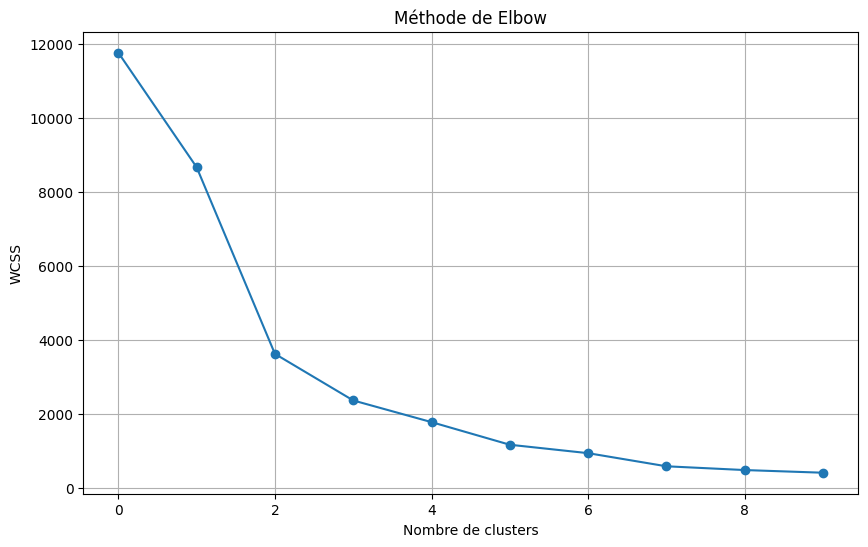

In [41]:
# Méthode de Elbow pour déterminer le nombre optimal de clusters
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(XS)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(wcss, marker='o')
plt.title('Méthode de Elbow')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


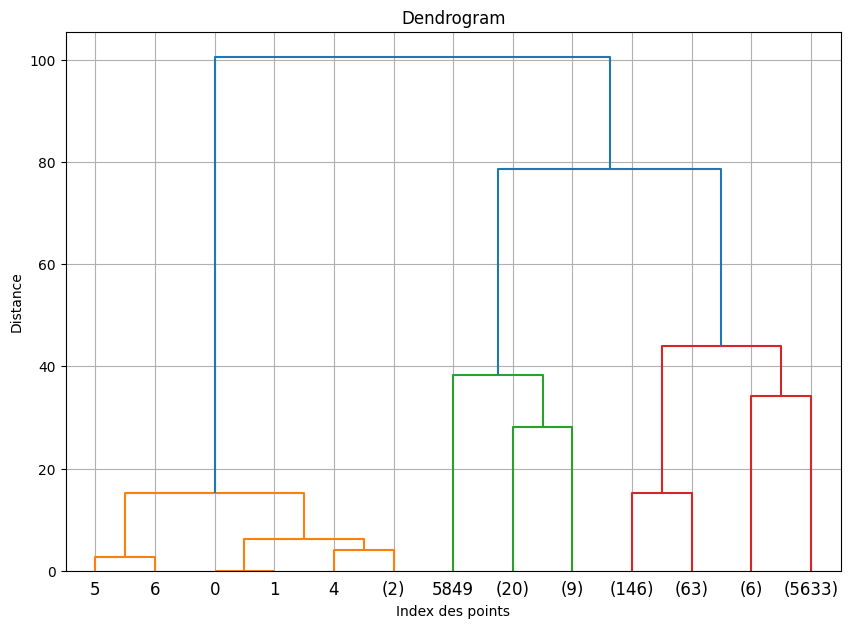

In [42]:
# Dendogramme pour déterminer le nombre optimal de clusters
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(XS, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=3)
plt.title('Dendrogram')
plt.xlabel('Index des points')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

Le nombre optimal de clusters d'après ce dendrogramme est 3.

Cela correspond à couper le dendrogramme juste en dessous de la plus grande fusion (autour de la distance ≈ 78), ce qui permet de capturer les trois groupes avant qu'ils ne soient réunis dans un cluster unique.

In [43]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=0)
km.fit(X)

KMeans(n_clusters=3, random_state=0)

In [44]:
# Récupération des labels de cluster
s_2['KM_Cluster'] = km.labels_
s_2.head()

,ProdId,Moves,Quantity,DB_Cluster,KM_Cluster
0,6222,6,250.000000,-1,0
1,5382,2,250.000000,-1,0
2,6214,12,232.916667,-1,0
3,5524,7,221.571429,-1,0
4,5559,1,200.000000,-1,0


In [45]:
# Afficher les valeurs uniques des clusters
s_2['KM_Cluster'].value_counts()

KM_Cluster
0    5677
2     198
1      10
Name: count, dtype: int64

In [46]:
# Afficher les centroïdes
km.cluster_centers_

array([[ 8.61898890e+01,  4.40750999e-01],
       [ 7.84040000e+03, -8.82001805e-02],
       [ 1.35374242e+03,  1.86351977e-02]])

Text(0.5, 1.0, 'KMeans Clustering of Moves vs QuantityMean')

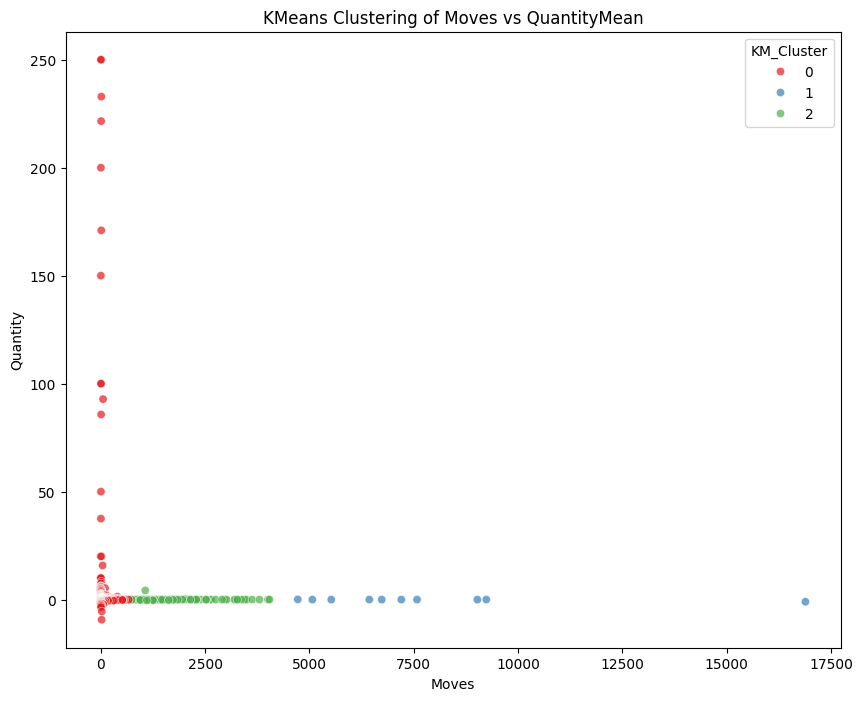

In [47]:
# Visualiser les clusters
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(
    data=s_2,
    x='Moves',
    y='Quantity',
    hue='KM_Cluster',
    palette='Set1',
    sizes=(20, 200),
    alpha=0.7
)
ax.set_title('KMeans Clustering of Moves vs QuantityMean')

In [48]:
# Calcule de silhouette score
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, km.labels_)
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.88


In [49]:
# Afficher les produits en excès de stock
seuil_exces = 1
exces = s_2[(s_2['KM_Cluster'] == 0) & (s_2['Quantity'] > seuil_exces)].copy()
exces = exces.merge(item_map, on='ProdId', how='left')
exces = exces[['Name', 'Moves', 'Quantity']]
exces

,Name,Moves,Quantity
0,BOUTEILLE PET 0.5 L RONDE,6,250.000000
1,MASQUE COQUE DET,2,250.000000
2,BOUCHON 28MM,12,232.916667
3,BOUCHONS PET,7,221.571429
4,FLACON A POMPE COULEUR BRUN AMBRE VIDE 300ML,1,200.000000
...,...,...,...
108,SACHET BIO DEGRADABLE MM P/500,69,1.188406
109,PARACETAMOL 500MG B/100 IPCA,7,1.142857
110,DELALOES GEL DOUCHE FL/200ML MASOALA,8,1.125000
111,SONDE VESICALE DE FOLEY CH14 A 2 VOIES,12,1.083333


**Afficher l'historique de mouvement d'un produit**

In [50]:
un_produit = exces['Name'].iloc[0]
print(un_produit)

un_produit_df = df[df['Name'] == un_produit]
un_produit_df.head()

BOUTEILLE PET 0.5 L RONDE


,BatchType,TransactionDate,Quantity,Name,ProdId,LastStock,CurrentStock
569218,6,2022-02-17 12:36:26.710,1000.0,BOUTEILLE PET 0.5 L RONDE,6222,0.0,1000.0
638461,6,2022-05-28 15:53:16.247,100.0,BOUTEILLE PET 0.5 L RONDE,6222,1000.0,1100.0
892589,6,2023-05-09 11:02:39.813,100.0,BOUTEILLE PET 0.5 L RONDE,6222,1100.0,1200.0
1124497,6,2024-02-06 17:08:26.893,100.0,BOUTEILLE PET 0.5 L RONDE,6222,1200.0,1300.0
1402404,6,2025-01-11 18:21:39.767,100.0,BOUTEILLE PET 0.5 L RONDE,6222,1300.0,1400.0


In [51]:
# Afficher les produits souvent en rupture de stock
seuil_rupture = -1
ruptures = s_2[(s_2['KM_Cluster'] == 0) & (s_2['Quantity'] < seuil_rupture)].copy()
ruptures = ruptures.merge(item_map, on='ProdId', how='left')
ruptures = ruptures[['ProdId', 'Name', 'Quantity']]
ruptures.sort_values(by='Quantity', ascending=True, inplace=True, ignore_index=True)
ruptures

,ProdId,Name,Quantity
0,5172,ABAISSE LANGUE EN BOIS AD DET,-9.315789
1,6936,BANDELETTE EXACTIVE EQ MICROTECH MEDICAL (HAN...,-5.478261
2,6076,GEL MAINS HYDROALCOOLIQUE BID/20L ABONDANCE,-3.500000
3,7660,GANT MAX CHAMP NITRILE MEDIUM DET 1 PAIRE,-3.000000
4,6834,ALESE CONFIANCE 60CM*60CM DET P/1 HARTMANN,-2.625000
5,7142,NIMOTOP 30MG CP PELL DET PL/10,-2.333333
6,4880,VITAMINE C 500MG CP B/10 X 10 DESKA,-2.105263
7,5908,NaN,-2.000000
8,7630,SAVIDION - VITAMINE K1 50MG AMP INJ DET,-2.000000
9,3615,NaN,-2.000000


### 5. Construire une série chronologique à partir des mouvements des produits qui ont sont en surstock et de forte rotation (si possible) (Approche 2)**